In [2]:
import yfinance as yf

data = yf.download("SPY", start="2015-01-01")
print(data.columns)

/tmp/ipython-input-3414009153.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2015-01-01")
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [3]:
import pandas as pd
import numpy as np
data.columns = data.columns.droplevel(1)

returns = np.log(data["Close"]).diff().dropna()
sigma = returns.std() * np.sqrt(252)

S0 = data["Close"].iloc[-1]

In [4]:
print("S0:", S0)
print("sigma:", sigma)

S0: 695.0900268554688
sigma: 0.1778523740776196


In [5]:
# Option parameters
K = S0
T = 1.0
r = 0.04
n_sim = 100000

In [6]:
Z = np.random.randn(n_sim)

ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

In [7]:
payoffs = np.maximum(ST - K, 0)

In [8]:
call_price_mc = np.exp(-r * T) * np.mean(payoffs)

print("Monte Carlo Call Price:", call_price_mc)

Monte Carlo Call Price: 63.60382833656507


In [9]:
put_payoffs = np.maximum(K - ST, 0)

put_price_mc = np.exp(-r * T) * np.mean(put_payoffs)

print("Monte Carlo Put Price:", put_price_mc)

Monte Carlo Put Price: 35.700222227448485


In [15]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [14]:
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [16]:
bs_price = black_scholes_call(S0, K, T, r, sigma)

print("Black–Scholes Price:", bs_price)
print("MC Error:", call_price_mc - bs_price)

Black–Scholes Price: 63.12822436477927
MC Error: 0.4756039717858016


In [17]:
bs_put = black_scholes_put(S0, K, T, r, sigma)

print("Black–Scholes Put:", bs_put)
print("MC Put Error:", put_price_mc - bs_put)

Black–Scholes Put: 35.87335457214965
MC Put Error: -0.17313234470116612


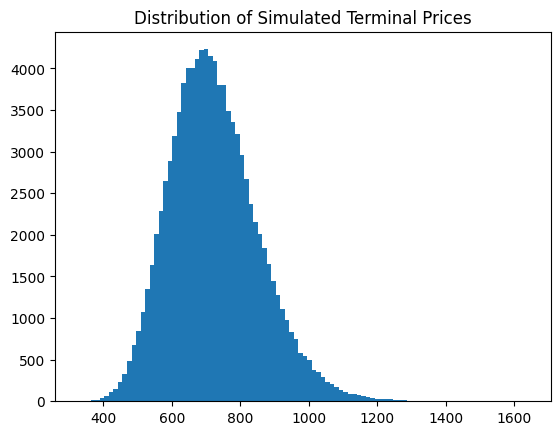

In [18]:
import matplotlib.pyplot as plt

plt.hist(ST, bins=100)
plt.title("Distribution of Simulated Terminal Prices")
plt.show()

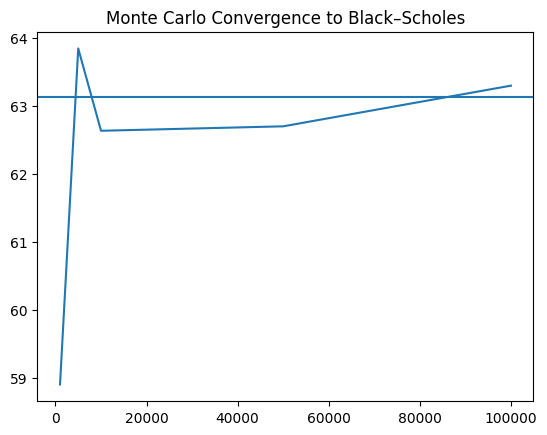

In [19]:
sims = [1000, 5000, 10000, 50000, 100000]
prices = []

for n in sims:
    Z = np.random.randn(n)
    ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoffs = np.maximum(ST - K, 0)
    price = np.exp(-r*T)*np.mean(payoffs)
    prices.append(price)

plt.plot(sims, prices)
plt.axhline(bs_price)
plt.title("Monte Carlo Convergence to Black–Scholes")
plt.show()

In [20]:
steps = 252
dt = T / steps
paths = np.zeros((n_sim, steps + 1))
paths[:, 0] = S0

for t in range(1, steps + 1):
    Z = np.random.randn(n_sim)
    paths[:, t] = paths[:, t-1] * np.exp(
        (r - 0.5 * sigma**2) * dt +
        sigma * np.sqrt(dt) * Z
    )
ST_paths = paths[:, -1]
call_payoffs = np.maximum(ST_paths - K, 0)
call_price_paths = np.exp(-r*T) * np.mean(call_payoffs)

put_payoffs = np.maximum(K - ST_paths, 0)
put_price_paths = np.exp(-r*T) * np.mean(put_payoffs)

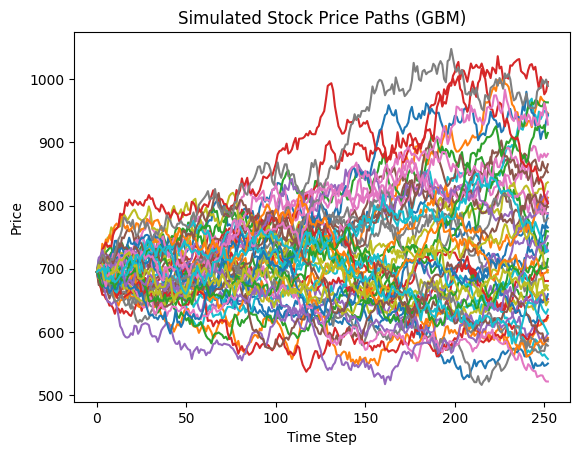

In [21]:
import matplotlib.pyplot as plt

for i in range(50):
    plt.plot(paths[i])

plt.title("Simulated Stock Price Paths (GBM)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.show()

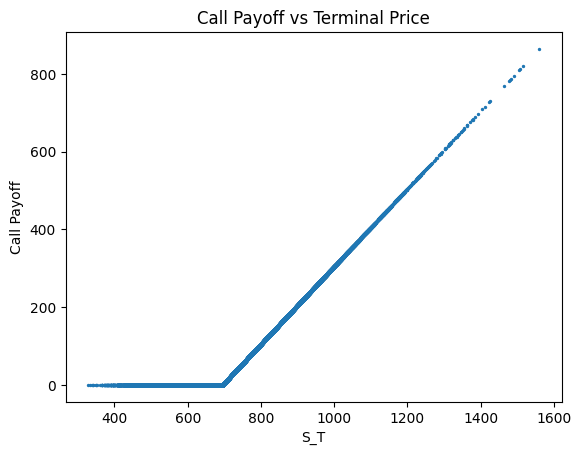

In [24]:
plt.scatter(ST_paths, call_payoffs, s=2)
plt.title("Call Payoff vs Terminal Price")
plt.xlabel("S_T")
plt.ylabel("Call Payoff")
plt.show()